In [285]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [248]:
df = pd.read_csv('../data/cleaned_heart.csv')

In [249]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140.0,289.0,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160.0,180.0,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130.0,283.0,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138.0,214.0,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150.0,195.0,0,Normal,122,N,0.0,Up,0


### Aiming for high recall remember!!

In [60]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [61]:
categorical_preprocessing = Pipeline([('ohe', OneHotEncoder())])
numerical_preprocessing = Pipeline([('imputer', KNNImputer(n_neighbors=5))])
preprocess = ColumnTransformer([
    ('categorical_preprocessing', categorical_preprocessing, ['ChestPainType','RestingECG','ST_Slope','Sex','FastingBS','ExerciseAngina']),
    ('numerical_preprocessing', numerical_preprocessing, ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']),
    ('scaler', StandardScaler(), ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak'])
])

In [62]:
pipeline_baseline = Pipeline([
    ('preprocess', preprocess),
    ('lr', LogisticRegression(max_iter=500))
])

In [129]:
pipeline_baseline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['ChestPainType',
                                                   'RestingECG', 'ST_Slope',
                                                   'Sex', 'FastingBS',
                                                   'ExerciseAngina']),
                                                 ('numerical_preprocessing',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('scaler', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak'])])),
                ('lr', LogisticRegression(max_iter=500))])

In [130]:
y_predicted = pipeline_baseline.predict(X_test)
r2 = r2_score(y_test, y_predicted)
acc = accuracy_score(y_test, y_predicted)
recal = recall_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted)
print('r2 score:', r2)
print('accuracy score:', acc)
print('recall score:', recal)
print('precision score:', precision)

r2 score: 0.321277239709443
accuracy score: 0.8304347826086956
recall score: 0.875
precision score: 0.7967479674796748


In [47]:
import pickle
pickle.dump(pipeline_baseline, open( "../models/baseline_pipeline", "wb" ) )

In [3]:
#baseline is done

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [90]:
pipeline_rfc = Pipeline([
    ('preprocess', preprocess),
    ('rfc', RandomForestClassifier())
])

In [91]:
params_rfc = {"rfc__n_estimators": [50, 100, 200],
                  "rfc__max_depth": [5, 10, 20]
                 }

In [92]:
gs_rfc = GridSearchCV(pipeline_rfc, params_rfc, cv=5)

In [124]:
gs_rfc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('categorical_preprocessing',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder())]),
                                                                         ['ChestPainType',
                                                                          'RestingECG',
                                                                          'ST_Slope',
                                                                          'Sex',
                                                                          'FastingBS',
                                                                          'ExerciseAngina']),
                                                                        ('numerical_preprocessing',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer())]),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak']),
                                                                        ('scaler',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak'])])),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'rfc__max_depth': [5, 10, 20],
                         'rfc__n_estimators': [50, 100, 200]})

In [125]:
gs_rfc.best_params_

{'rfc__max_depth': 10, 'rfc__n_estimators': 50}

In [126]:
rfc_best = gs_rfc.best_estimator_

In [127]:
y_predicted = rfc_best.predict(X_test)

In [128]:
r2 = r2_score(y_test, y_predicted)
acc = accuracy_score(y_test, y_predicted)
recal = recall_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted)
print('r2 score:', r2)
print('accuracy score:', acc)
print('recall score:', recal)
print('precision score:', precision)

r2 score: 0.37348668280871655
accuracy score: 0.8434782608695652
recall score: 0.9107142857142857
precision score: 0.796875


In [165]:
#save this model to compare to one created after
import pickle
pickle.dump(rfc_best, open( "../models/initial_rfc_pipeline", "wb" ) )

In [23]:
#This RFC model has a better recall than the baseline
#find out best features from it and reduce (background stuff can just be noise)

In [131]:
pipeline_svc = Pipeline([
    ('preprocess', preprocess),
    ('svc', SVC())
])

In [132]:
params_svc = {"svc__C": [0.1, 1.0, 10],
                "svc__kernel": ['linear'],
              'svc__gamma': [1, 0.1, 0.01, 0.001]
                 }

In [133]:
gs_svc = GridSearchCV(pipeline_svc, params_svc, cv=5)

In [134]:
gs_svc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('categorical_preprocessing',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder())]),
                                                                         ['ChestPainType',
                                                                          'RestingECG',
                                                                          'ST_Slope',
                                                                          'Sex',
                                                                          'FastingBS',
                                                                          'ExerciseAngina']),
                                                                        ('numerical_preprocessing',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer())]),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak']),
                                                                        ('scaler',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak'])])),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.1, 1.0, 10],
                         'svc__gamma': [1, 0.1, 0.01, 0.001],
                         'svc__kernel': ['linear']})

In [135]:
svc_best = gs_svc.best_estimator_

In [136]:
y_predicted = svc_best.predict(X_test)

In [137]:
r2 = r2_score(y_test, y_predicted)
acc = accuracy_score(y_test, y_predicted)
recal = recall_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted)
print('r2 score:', r2)
print('accuracy score:', acc)
print('recall score:', recal)
print('precision score:', precision)

r2 score: 0.26906779661016933
accuracy score: 0.8173913043478261
recall score: 0.8571428571428571
precision score: 0.7868852459016393


In [138]:
#svc linear kernal performed worse than rfc

In [75]:
#low chance this will even be good
from sklearn.naive_bayes import GaussianNB
pipeline_nb = Pipeline([
    ('preprocess', preprocess),
    ('nb', GaussianNB())
])

In [78]:
pipeline_nb.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['ChestPainType',
                                                   'RestingECG', 'ST_Slope',
                                                   'Sex', 'FastingBS',
                                                   'ExerciseAngina']),
                                                 ('numerical_preprocessing',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('scaler', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak'])])),
                ('nb', GaussianNB())])

In [79]:
y_predicted = pipeline_nb.predict(X_test)

In [80]:
r2 = r2_score(y_test, y_predicted)
acc = accuracy_score(y_test, y_predicted)
recal = recall_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted)
print('r2 score:', r2)
print('accuracy score:', acc)
print('recall score:', recal)
print('precision score:', precision)

r2 score: 0.2884159555736149
accuracy score: 0.8229317851959361
recall score: 0.8288043478260869
precision score: 0.8379120879120879


In [81]:
#worst model so far

In [37]:
#getting feature importances from random forest

In [69]:
ohe = OneHotEncoder(sparse=False)
ohe_df = ohe.fit_transform(df[['ChestPainType','RestingECG','ST_Slope','Sex','FastingBS','ExerciseAngina']])

In [70]:
col_names = ohe.get_feature_names_out()

In [71]:
ohe_df = pd.DataFrame(ohe_df, columns = col_names)

In [76]:
ss = StandardScaler()
scaled = ss.fit_transform(df[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']])
names = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']

In [78]:
scaled = pd.DataFrame(scaled, columns = names)

In [80]:
combined = pd.concat([scaled, ohe_df], axis=1, join='inner')

In [152]:
column_names = combined.columns

In [144]:
from sklearn.model_selection import train_test_split
X = combined
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [145]:
clf = RandomForestClassifier(max_depth=10, n_estimators=50)

In [147]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=50)

In [149]:
y_predicted = clf.predict(X_test)

In [150]:
r2 = r2_score(y_test, y_predicted)
acc = accuracy_score(y_test, y_predicted)
recal = recall_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted)
print('r2 score:', r2)
print('accuracy score:', acc)
print('recall score:', recal)
print('precision score:', precision)

r2 score: 0.4608695652173913
accuracy score: 0.8652173913043478
recall score: 0.9217391304347826
precision score: 0.828125


In [ ]:
#similar to created model from pipeline, can now extract feature importances easier as well

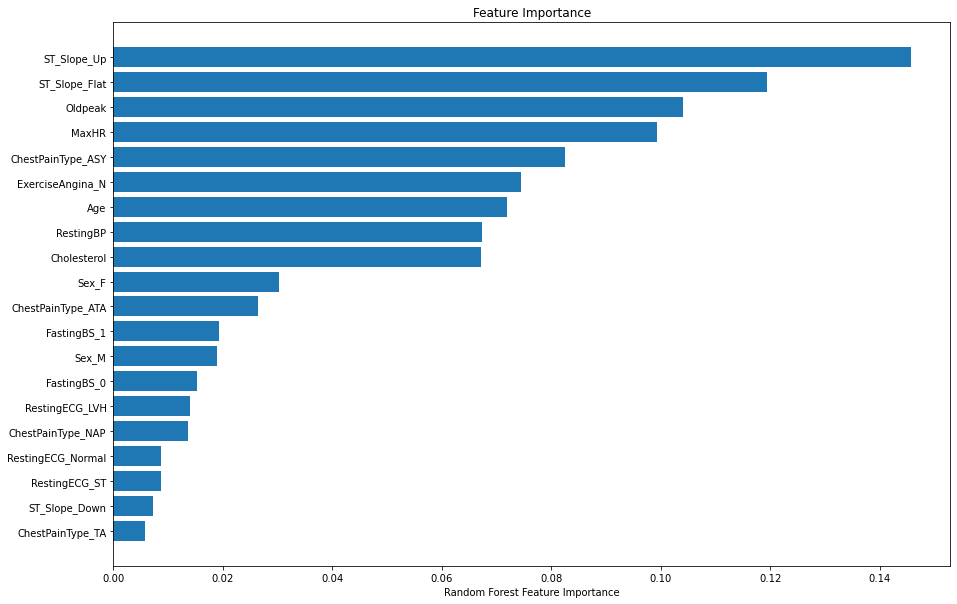

In [158]:
plt.figure(figsize=(15,10))
feature_imp = clf.feature_importances_
indexs = np.argsort(feature_imp)
plt.title("Feature Importance")
plt.barh(range(len(indexs)),feature_imp[indexs],align="center")
plt.yticks(range(len(indexs)),[column_names[i] for i in indexs])
plt.xlabel("Random Forest Feature Importance")
#plt.tight_layout()
plt.show()

In [3]:
plt.savefig('../figures/feature_importance.png')

<Figure size 432x288 with 0 Axes>

In [159]:
#Based on what is seen from this graph, ST slope, old peak, max heart rate, chest pain type (but only asy or not symp), age, max hr, resting bp and cholesterol make up most of 
#the importance, can cut down features such as resting ECG, fasting BS, even sex doesnt seem to be too important, and retrain a new model

In [ ]:
#previous had 91% recall

In [4]:
df = pd.read_csv('../data/features_removed_heart.csv')

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [51]:
#same pipeline
categorical_preprocessing = Pipeline([('ohe', OneHotEncoder())])
numerical_preprocessing = Pipeline([('imputer', KNNImputer(n_neighbors=5))])
preprocess = ColumnTransformer([
    ('categorical_preprocessing', categorical_preprocessing, ['ChestPainType','ST_Slope','ExerciseAngina']),
    ('numerical_preprocessing', numerical_preprocessing, ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']),
    ('scaler', StandardScaler(), ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak'])
])

In [52]:
rfc = RandomForestClassifier(max_depth=10, n_estimators= 50)

In [53]:
rfc_pipe = Pipeline([
    ('preprocess', preprocess),
    ('rfc', rfc)
])

In [54]:
rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['ChestPainType', 'ST_Slope',
                                                   'ExerciseAngina']),
                                                 ('numerical_preprocessing',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('scaler', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak'])])),
                ('rfc', RandomForestClassifier(max_depth=10, n_estimators=50))])

In [55]:
y_predicted = rfc_pipe.predict(X_test)
r2 = r2_score(y_test, y_predicted)
acc = accuracy_score(y_test, y_predicted)
recal = recall_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted)
print('r2 score:', r2)
print('accuracy score:', acc)
print('recall score:', recal)
print('precision score:', precision)

r2 score: 0.5787545787545787
accuracy score: 0.8956521739130435
recall score: 0.9285714285714286
precision score: 0.8863636363636364


In [56]:
#improved recall score around ~2%

In [68]:
rfc_pipe.steps[1][1].feature_importances_

array([0.08080771, 0.04684614, 0.00296916, 0.1184075 , 0.1177245 ,
       0.0314854 , 0.04527635, 0.05167804, 0.04178271, 0.04555148,
       0.06173239, 0.06359369, 0.04987081, 0.04857785, 0.0458815 ,
       0.05991619, 0.08789859])

In [71]:
#save this model to compare to one created after
import pickle
pickle.dump(rfc_pipe, open( "../models/features_removed_rfc_pipeline", "wb" ) )

In [72]:
df = pd.read_csv('../data/somefeatures_removed_heart.csv')

In [93]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [94]:
categorical_preprocessing = Pipeline([('ohe', OneHotEncoder())])
numerical_preprocessing = Pipeline([('imputer', KNNImputer(n_neighbors=5))])
preprocess = ColumnTransformer([
    ('categorical_preprocessing', categorical_preprocessing, ['ChestPainType','ST_Slope','ExerciseAngina']),
    ('numerical_preprocessing', numerical_preprocessing, ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']),
    ('scaler', StandardScaler(), ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak'])
])
rfc = RandomForestClassifier(max_depth=10, n_estimators= 50)
rfc_pipe = Pipeline([
    ('preprocess', preprocess),
    ('rfc', rfc)
])

In [95]:
rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['ChestPainType', 'ST_Slope',
                                                   'ExerciseAngina']),
                                                 ('numerical_preprocessing',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('scaler', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak'])])),
                ('rfc', RandomForestClassifier(max_depth=10, n_estimators=50))])

In [96]:
y_predicted = rfc_pipe.predict(X_test)
r2 = r2_score(y_test, y_predicted)
acc = accuracy_score(y_test, y_predicted)
recal = recall_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted)
print('r2 score:', r2)
print('accuracy score:', acc)
print('recall score:', recal)
print('precision score:', precision)

r2 score: 0.4582478535065725
accuracy score: 0.8652173913043478
recall score: 0.9186991869918699
precision score: 0.8432835820895522


In [97]:
#recall score went down, try sequential forward selection

In [4]:
#go up to 15 features
import pickle
initial_rfc = pickle.load(open( "../models/initial_rfc_pipeline", "rb" ) )

In [ ]:
#use original data for this

In [13]:
df = pd.read_csv('../data/cleaned_heart.csv')

In [21]:
#pipeline not working with SFS, need to use the standalone model built before

In [80]:
ohe = OneHotEncoder(sparse=False)
ohe_df = ohe.fit_transform(df[['ChestPainType','RestingECG','ST_Slope','Sex','FastingBS','ExerciseAngina']])
col_names = ohe.get_feature_names_out()
ohe_df = pd.DataFrame(ohe_df, columns = col_names)
ss = StandardScaler()
scaled = ss.fit_transform(df[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']])
names = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
scaled = pd.DataFrame(scaled, columns = names)
combined = pd.concat([scaled, ohe_df], axis=1, join='inner')
column_names = combined.columns
X = combined
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [60]:
clf = RandomForestClassifier(max_depth=10, n_estimators=50)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=50)

In [61]:
y_predicted = clf.predict(X_test)

In [62]:
#similar scores, use for SFS
r2 = r2_score(y_test, y_predicted)
acc = accuracy_score(y_test, y_predicted)
recal = recall_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted)
print('r2 score:', r2)
print('accuracy score:', acc)
print('recall score:', recal)
print('precision score:', precision)

r2 score: 0.4814987562189056
accuracy score: 0.8739130434782608
recall score: 0.9104477611940298
precision score: 0.8776978417266187


In [73]:
#use mlxtend SFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [82]:
sfs = SFS(clf, 
          k_features=15, 
          forward=True, 
          scoring='roc_auc',
          verbose=2)

In [83]:
sfs = sfs.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    7.2s finished

[2022-09-13 17:16:47] Features: 1/15 -- score: 0.7988778283143559[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.3s finished

[2022-09-13 17:16:54] Features: 2/15 -- score: 0.8718113519701374[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    7.2s finished

[2022-09-13 17:17:02] Features: 3/15 -- score: 0.892765927606864[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

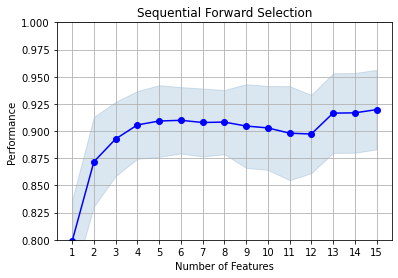

In [453]:
#around 5 features is where is plateaus until it picks up again around 13, where it puts oldpeak in, so pick the features at 5 + old peak
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),
                kind='std_dev',
                figsize=(6, 4))

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

In [85]:
sfs.get_metric_dict()

{1: {'feature_idx': (14,),
  'cv_scores': array([0.80902704, 0.72389643, 0.82427844, 0.82269198, 0.81449525]),
  'avg_score': 0.7988778283143559,
  'feature_names': ('ST_Slope_Up',),
  'ci_bound': 0.04871040439751283,
  'std_dev': 0.03789834947379907,
  'std_err': 0.018949174736899534},
 2: {'feature_idx': (5, 14),
  'cv_scores': array([0.88513945, 0.79244482, 0.90386248, 0.90358067, 0.87402934]),
  'avg_score': 0.8718113519701374,
  'feature_names': ('ChestPainType_ASY', 'ST_Slope_Up'),
  'ci_bound': 0.053050507687156225,
  'std_dev': 0.04127509728071502,
  'std_err': 0.02063754864035751},
 3: {'feature_idx': (5, 14, 16),
  'cv_scores': array([0.91473281, 0.82523345, 0.91012309, 0.90142364, 0.91231665]),
  'avg_score': 0.892765927606864,
  'feature_names': ('ChestPainType_ASY', 'ST_Slope_Up', 'Sex_M'),
  'ci_bound': 0.043781611359661673,
  'std_dev': 0.03406358104305189,
  'std_err': 0.017031790521525945},
 4: {'feature_idx': (5, 14, 16, 17),
  'cv_scores': array([0.93740686, 0.853565

In [87]:
sfs.get_metric_dict()[5]['feature_names']

('ChestPainType_ASY',
 'ST_Slope_Up',
 'Sex_M',
 'FastingBS_0',
 'ExerciseAngina_Y')

In [88]:
#for our final model training, use chest pain type, st slope, sex, fasting blood sugar, exercise angina, and oldpeak

In [288]:
df = pd.read_csv('../data/sfs_features.csv')

In [289]:
df.head()

,Sex,ChestPainType,FastingBS,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,M,SYM,0,N,0.0,Up,0
1,F,SYM,0,N,1.0,Flat,1
2,M,SYM,0,N,0.0,Up,0
3,F,ASY,0,Y,1.5,Flat,1
4,M,SYM,0,N,0.0,Up,0


In [91]:
categorical_preprocessing = Pipeline([('ohe', OneHotEncoder())])
numerical_preprocessing = Pipeline([('imputer', KNNImputer(n_neighbors=5))])
preprocess = ColumnTransformer([
    ('categorical_preprocessing', categorical_preprocessing, ['ChestPainType','ST_Slope','Sex','ExerciseAngina']),
    ('numerical_preprocessing', numerical_preprocessing, ['FastingBS','Oldpeak']),
    ('scaler', StandardScaler(), ['FastingBS','Oldpeak'])
])

In [115]:
pipeline_rfc = Pipeline([
    ('preprocess', preprocess),
    ('rfc', RandomForestClassifier(max_depth=10, n_estimators=50))
])

In [290]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [108]:
pipeline_rfc.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['ChestPainType', 'ST_Slope',
                                                   'Sex', 'ExerciseAngina']),
                                                 ('numerical_preprocessing',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['FastingBS', 'Oldpeak']),
                                                 ('scaler', StandardScaler(),
                                                  ['FastingBS', 'Oldpeak'])])),
                ('rfc', RandomForestClassifier(max_depth=10, n_estimators=50))])

In [109]:
y_predicted=pipeline_rfc.predict(X_test)

In [110]:
r2 = r2_score(y_test, y_predicted)
acc = accuracy_score(y_test, y_predicted)
recal = recall_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted)
print('r2 score:', r2)
print('accuracy score:', acc)
print('recall score:', recal)
print('precision score:', precision)

r2 score: 0.4400486914181376
accuracy score: 0.8608695652173913
recall score: 0.9193548387096774
precision score: 0.8382352941176471


In [111]:
#92% recall with only 6 features kept

In [113]:
categorical_preprocessing = Pipeline([('ohe', OneHotEncoder()), ('imputer', SimpleImputer(missing_values=np.NaN, strategy='median'))])
numerical_preprocessing = Pipeline([('imputer', KNNImputer(n_neighbors=5))])
preprocess = ColumnTransformer([
    ('categorical_preprocessing', categorical_preprocessing, ['ChestPainType','ST_Slope','Sex','ExerciseAngina']),
    ('numerical_preprocessing', numerical_preprocessing, ['FastingBS','Oldpeak']),
    ('scaler', StandardScaler(), ['FastingBS','Oldpeak'])
])

In [116]:
pipeline_rfc_imputer_added = Pipeline([
    ('preprocess', preprocess),
    ('rfc', RandomForestClassifier(max_depth=10, n_estimators=50))
])

In [117]:
pipeline_rfc_imputer_added.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['ChestPainType', 'ST_Slope',
                                                   'Sex', 'ExerciseAngina']),
                                                 ('numerical_preprocessing',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['FastingBS', 'Oldpeak']),
                                                 ('scaler', StandardScaler(),
                                                  ['FastingBS', 'Oldpeak'])])),
                ('rfc', RandomForestClassifier(max_depth=10, n_estimators=50))])

In [468]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [469]:
y_predicted_imputer=pipeline_rfc_imputer_added.predict(X_test)
r2 = r2_score(y_test, y_predicted_imputer)
acc = accuracy_score(y_test, y_predicted_imputer)
recal = recall_score(y_test, y_predicted_imputer)
precision = precision_score(y_test, y_predicted_imputer)
print('r2 score:', r2)
print('accuracy score:', acc)
print('recall score:', recal)
print('precision score:', precision)

r2 score: 0.5787545787545787
accuracy score: 0.8956521739130435
recall score: 0.9126984126984127
precision score: 0.8984375


In [121]:
#now it can take in any nan values and fill numericals with knnimputer or categorical with median

In [122]:
pickle.dump(pipeline_rfc_imputer_added, open( "../models/final_pipeline", "wb" ) )

In [240]:
from sklearn.model_selection import cross_validate

In [241]:
cv = cross_validate(pipeline_rfc_imputer_added, X_test, y_test, cv=5, scoring = 'recall')

In [242]:
print(cv['test_score'].mean())

0.8546666666666667


In [243]:
baseline_model = pickle.load(open( "../models/baseline_pipeline", "rb" ) )

In [244]:
#baseline used initial df
df = pd.read_csv('../data/cleaned_heart.csv')
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [245]:
cv = cross_validate(baseline_model, X_test, y_test, cv=5, scoring = 'recall')

In [246]:
print(cv['test_score'].mean())

0.8192028985507246


In [360]:
df_feat_removed = pd.read_csv('../data/features_removed_heart.csv')

In [426]:
df_feat_removed.head()

,Age,ChestPainType,RestingBP,Cholesterol,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,SYM,140.0,289.0,172,N,0.0,Up,0
1,49,SYM,160.0,180.0,156,N,1.0,Flat,1
2,37,SYM,130.0,283.0,98,N,0.0,Up,0
3,48,ASY,138.0,214.0,108,Y,1.5,Flat,1
4,54,SYM,150.0,195.0,122,N,0.0,Up,0


In [361]:
feat_removed_model = pickle.load(open( "../models/features_removed_rfc_pipeline", "rb" ) )

In [447]:
X = df_feat_removed.iloc[:,:-1]
y = df_feat_removed.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [448]:
y_predicted_feat_removed=feat_removed_model.predict(X_test)

In [449]:
r2 = r2_score(y_test, y_predicted_feat_removed)
acc = accuracy_score(y_test, y_predicted_feat_removed)
recal = recall_score(y_test, y_predicted_feat_removed)
precision = precision_score(y_test, y_predicted_feat_removed)
print('r2 score:', r2)
print('accuracy score:', acc)
print('recall score:', recal)
print('precision score:', precision)

r2 score: 0.9293882876659759
accuracy score: 0.9826086956521739
recall score: 0.9767441860465116
precision score: 0.9921259842519685


In [429]:
cv = cross_validate(feat_removed_model, X_test, y_test, cv=5, scoring = 'recall')

In [430]:
print(cv['test_score'].mean())

0.9088319088319089


In [251]:
df.head()

,Sex,ChestPainType,FastingBS,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,M,SYM,0,N,0.0,Up,0
1,F,SYM,0,N,1.0,Flat,1
2,M,SYM,0,N,0.0,Up,0
3,F,ASY,0,Y,1.5,Flat,1
4,M,SYM,0,N,0.0,Up,0


In [270]:
want_pred = {'Sex':['M'],'ChestPainType':['SYM'],'FastingBS':[0],'ExerciseAngina':['N'],'Oldpeak':[0.0],'ST_Slope':['Up']}

In [272]:
want_pred = pd.DataFrame.from_dict(want_pred)

In [262]:
array_want_pred = np.array(want_pred)

In [279]:
predi=pipeline_rfc_imputer_added.predict_proba(want_pred)

In [284]:
predi[0][0]

0.9626839761022359

In [291]:
y_predicted_imputer=pipeline_rfc_imputer_added.predict(X_test)

Text(0.5, 1.0, 'Confusion matrix')

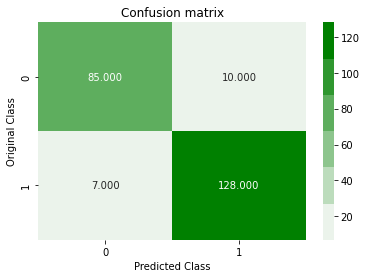

In [293]:
C = confusion_matrix(y_test, y_predicted_imputer)
labels = [0,1]
cmap=sns.light_palette("green")
sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title("Confusion matrix")

Text(0.5, 1.0, 'Confusion matrix')

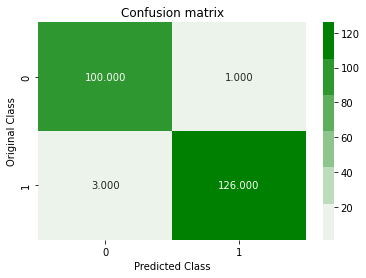

In [450]:
C = confusion_matrix(y_test, y_predicted_feat_removed)
labels = [0,1]
cmap=sns.light_palette("green")
sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title("Confusion matrix")

In [305]:
unique, counts = np.unique(y_predicted_imputer, return_counts=True)
dict(zip(unique, counts))

{0: 92, 1: 138}

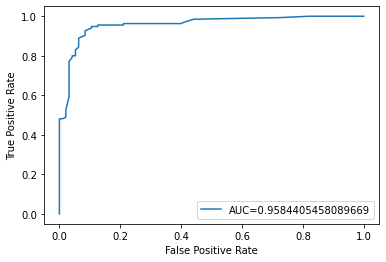

In [302]:
#get auc, helps know how good model is
from sklearn import metrics
y_pred_proba = pipeline_rfc_imputer_added.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)


plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

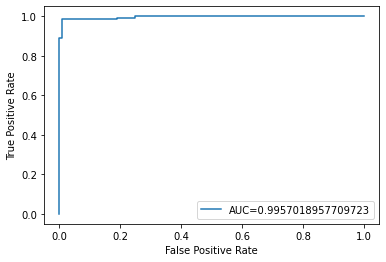

In [451]:
#get auc, helps know how good model is
from sklearn import metrics
y_pred_proba = feat_removed_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)


plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [470]:
pickle.dump(feat_removed_model, open( "../models/feat_imp_final_pipeline", "wb" ) )

In [304]:
from sklearn.metrics import log_loss
log_loss(y_test, y_predicted_imputer)

2.5529008464686247

In [452]:
from sklearn.metrics import log_loss
log_loss(y_test, y_predicted_feat_removed)

0.6006778485959701